In [1]:
import wandb
wandb.login() 
# 8599fbb702cb5767e13d2ac3b1cdcc1c9b65d451

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yadix. Use `wandb login --relogin` to force relogin


True

In [2]:
from tem_dataloader import MultimodalDataset
environment_name = 'AbandonedFactoryExposure'
my_dataset = MultimodalDataset(f'/mnt/data/tartanairv2filtered/{environment_name}/Data_easy')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Processing folder: /mnt/data/tartanairv2filtered/AbandonedFactoryExposure/Data_easy/P001
Processing folder: /mnt/data/tartanairv2filtered/AbandonedFactoryExposure/Data_easy/P004
Processing folder: /mnt/data/tartanairv2filtered/AbandonedFactoryExposure/Data_easy/P006
Processing folder: /mnt/data/tartanairv2filtered/AbandonedFactoryExposure/Data_easy/P005
Processing folder: /mnt/data/tartanairv2filtered/AbandonedFactoryExposure/Data_easy/P008
Processing folder: /mnt/data/tartanairv2filtered/AbandonedFactoryExposure/Data_easy/P002
Processing folder: /mnt/data/tartanairv2filtered/AbandonedFactoryExposure/Data_easy/P009
Processing folder: /mnt/data/tartanairv2filtered/AbandonedFactoryExposure/Data_easy/P003
Processing folder: /mnt/data/tartanairv2filtered/AbandonedFactoryExposure/Data_easy/P000
Number of images: 8185
Number 

In [3]:
from torch.utils.data import DataLoader, Dataset
batch_size = 32
train_dataloader = DataLoader(my_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

In [1]:
from custom_models.CustomViT import CustomViT
from custom_models.CustomViTMAE import CustomViTMAE
import torch
# call CustomViT
from transformers import AutoImageProcessor, ViTMAEForPreTraining, ViTMAEConfig
from PIL import Image

# output_dir='/home/tyz/Desktop/11_777/camelmera/weights'
trained_model_name = 'multimodal'
output_dir='/home/ubuntu/weights/' + trained_model_name

# Initialize a new CustomViT model
model_name = "facebook/vit-mae-base"
vit_config = ViTMAEConfig.from_pretrained(model_name)
vit_config.output_hidden_states=True
vit_model = CustomViT(config=vit_config)

# Initialize a new CustomViTMAE model
model_name = "facebook/vit-mae-base"
config = ViTMAEConfig.from_pretrained(model_name)
config.output_hidden_states=True
custom_model = CustomViTMAE(config=config)
custom_model.vit = vit_model

# Load the state_dict from the saved model
state_dict = torch.load(f"{output_dir}/pytorch_model.bin")
custom_model.load_state_dict(state_dict)

# don't need decoders
vit_encoder = custom_model.vit

In [2]:
from dataloader import process_image,process_depth,process_lidar

environment_name = 'AbandonedFactoryExposure'
dataset_dir = f'/mnt/data/tartanairv2filtered/{environment_name}/Data_easy'

# pixel_values = process_image('/home/tyz/Desktop/11_777/Data_easy/P000/image_lcam_fish/000000_lcam_fish_image.png').unsqueeze(0).cuda()
# pixel_values1 = process_depth('/home/tyz/Desktop/11_777/Data_easy/P000/depth_lcam_fish/000000_lcam_fish_depth.png').unsqueeze(0).cuda()
# pixel_values2 = process_lidar('/home/tyz/Desktop/11_777/Data_easy/P000/lidar/000000_lcam_front_lidar.ply').unsqueeze(0).cuda()
pixel_values = process_image(dataset_dir+'/P000/image_lcam_fish/000000_lcam_fish_image.png').unsqueeze(0).cuda()
pixel_values1 = process_depth(dataset_dir+'/P000/depth_lcam_fish/000000_lcam_fish_depth.png').unsqueeze(0).cuda()
pixel_values2 = process_lidar(dataset_dir+'/P000/lidar/000000_lcam_front_lidar.ply').unsqueeze(0).cuda()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from tem_dataloader import process_image,process_depth,process_lidar
from PIL import Image 

custom_model.cuda()
custom_model.eval()
with torch.no_grad():
    outputs = custom_model(pixel_values,pixel_values1,pixel_values2)
    print(outputs.loss)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 14.61 GiB total capacity; 1.26 GiB already allocated; 1.19 MiB free; 1.31 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(outputs.logits.shape)
tensor=custom_model.unpatchify(outputs.logits)
print(tensor.shape)

torch.Size([1, 196, 768])
torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


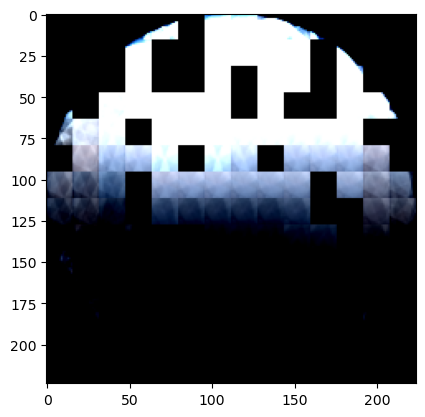

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Convert the tensor to a NumPy array and transpose the dimensions to HWC
image = tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()

# Visualize the image using Matplotlib
plt.imshow(image)
plt.show()

In [ ]:
custom_model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        pixel_values = batch["pixel_values"].to(device)
        pixel_values1 = batch["pixel_values1"].to(device)
        pixel_values2 = batch["pixel_values2"].to(device)
        outputs = custom_model(pixel_values, pixel_values1, pixel_values2)
        break

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

In [ ]:
print(outputs.loss)
print(outputs.logits.shape)


NameError: name 'outputs' is not defined

In [ ]:
import time
def train(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    total_samples = 0
    
    for batch in dataloader:
        # print(batch.keys())
        pixel_values = batch["pixel_values"].to(device)
        pixel_values1 = batch["pixel_values1"].to(device)
        pixel_values2 = batch["pixel_values2"].to(device)
        # batch = {k: v.to(device) for k, v in batch.items()}

        # bf_forward = time.time()

        optimizer.zero_grad()
        outputs = model(pixel_values,pixel_values1,pixel_values2,noise=None)

        # af_forward = time.time()
        # print("forward time: ", af_forward - bf_forward)

        loss = outputs.loss
        loss.backward()

        # af_backward = time.time()
        # print("backward time: ", af_backward - af_forward)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # af_step = time.time()
        # print("step time: ", af_step - af_backward)

        total_loss += loss.item() * pixel_values.size(0)
        total_samples += pixel_values.size(0)

        if total_samples % (batch_size * 1) == 0: # log every 1 batches
          wandb.log({'loss': loss.item()} )
          print(loss.item())
        
        # af_loss_cal = time.time()
        # print("loss cal time: ", af_loss_cal - af_step)

    return total_loss / total_samples


In [ ]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup

epochs = 1
learning_rate = 0.01
weight_decay = 0.01
warmup_steps = 0
total_steps = len(train_dataloader) * epochs
optimizer = AdamW(custom_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
custom_model.to(device)


cuda


/home/tyz/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


CustomViTMAE(
  (vit): CustomViT(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
 

In [ ]:
wandb.init(project="11777",name=environment_name+time.strftime("%Y%m%d-%H%M%S"))
for epoch in range(epochs):
    train_loss = train(custom_model, train_dataloader, optimizer, scheduler, device)
    print(f"Epoch: {epoch + 1}, Loss: {train_loss:.4f}")
    output_dir='/home/tyz/Desktop/11_777/camelmera/weights'
    custom_model.save_pretrained(output_dir)
wandb.finish()

KeyboardInterrupt: 

In [ ]:
output_dir='/home/tyz/Desktop/11_777/camelmera/weights'
custom_model.save_pretrained(output_dir)